In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np
import optax

In [2]:
from phasor_jax.modules import *
from phasor_jax.utils import *
from phasor_jax.training import *

In [3]:
import matplotlib.pyplot as plt

# Dataset

In [4]:
#choose standard dataset here - e.g. MNIST, Fashion MNIST, Kuzushiji MNIST
dataset = "fashion_mnist"

In [5]:
#load the dataset
n_batch = 128
train_ds, x_train, y_train = load_dataset(dataset, split="train", is_training=True, batch_size=n_batch)
train = iter(train_ds)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-03-22 14:45:36.528445: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
n_train = x_train.shape[0]
x_train.shape

(60000, 28, 28, 1)

# Model

In [7]:
def in_layer(x, 
           vsa_dimension: int = 1024,
           spiking: bool = False,
           **kwargs):
    
    x = scale_mnist(x)
    #project into VSA
    x = ProjectAll(vsa_dimension)(x)
    x = layer_norm(x)

    return x

In [40]:
def mlp(x, 
           vsa_dimension: int = 1024,
           spiking: bool = False,
           repeats: int = 3,
           **kwargs):
    
    x = scale_mnist(x)
    #project into VSA
    x = ProjectAll(vsa_dimension)(x)
    x = layer_norm(x)

    if spiking:
        x = phase_to_train(x, repeats=repeats)
    
    x = conv_1d(128)(x, spiking=spiking)
    x = conv_1d(10)(x,  spiking=spiking)

    if spiking: 
        x = train_to_phase(x, offset=-0.25)
     
    return x

In [41]:
#declare the model as a transformation
model = hk.transform(mlp)

In [42]:
#instantiate the first PRNG key
key = jrnd.PRNGKey(42)

In [11]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)
params = model.init(subkey, x_train[0:10,...])

/Users/wilkie/anaconda3/envs/jax/lib/python3.10/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [12]:
#create an instance of the RMSprop optimizer
opt = optax.rmsprop(0.001)

In [13]:
#get a sample batch from the train set
b = next(train)
x = b['image']
y = b['label']

b x y c ->  (128, 28, 28, 1)


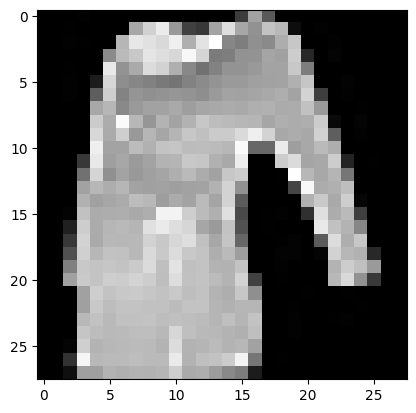

In [14]:
print("b x y c -> ", x.shape)
plt.imshow(x[0,...], cmap="gray");

Text(0, 0.5, 'Density')

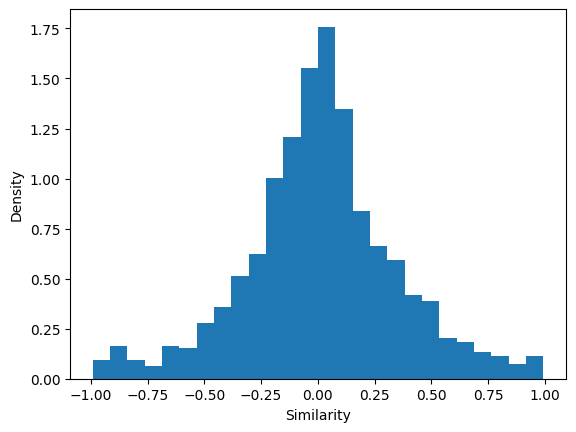

In [15]:
#sample the initial similarities the model produces between an 
# image and the class codebook. 

pred = model.apply(params, key, x)

plt.hist(np.array(pred.ravel()), bins=26, density=True)
plt.xlabel("Similarity")
plt.ylabel("Density")

Text(0.5, 1.0, 'Pre-Train Similarity')

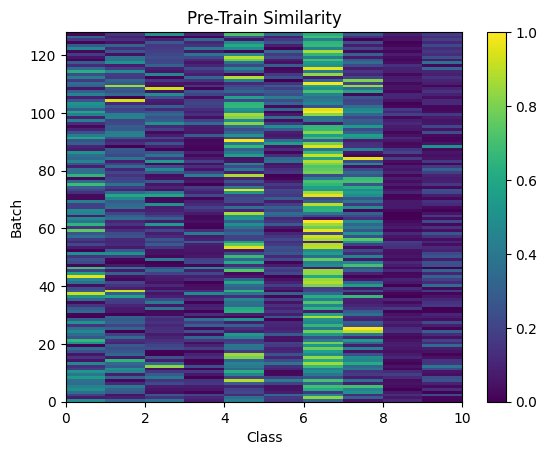

In [16]:
#Visualize the similarity each sample produces to the class codebook
plt.pcolor(jnp.abs(pred), vmax=1.0, vmin=0.0)
plt.xlabel("Class")
plt.ylabel("Batch")
plt.colorbar()
plt.title("Pre-Train Similarity")

In [17]:
loss_fn = lambda yh, y: quadrature_loss(yh, y, num_classes=10)

In [18]:
# Compute a sample of the loss function over these similarities. 
# Takes the complement of the similarity for the correct class label.
# This value (distance) will be minimized over training.

jnp.mean(loss_fn(pred, y))

DeviceArray(0.4549652, dtype=float32)

# Training

In [19]:
params_t, losses = train_model(model, 
                               key, 
                               params = params, 
                               dataset = train, 
                               optimizer = opt, 
                               loss_fn = loss_fn, 
                               batches = 1000)

100%|██████████| 1000/1000 [00:32<00:00, 30.51it/s]


Text(0, 0.5, 'Loss')

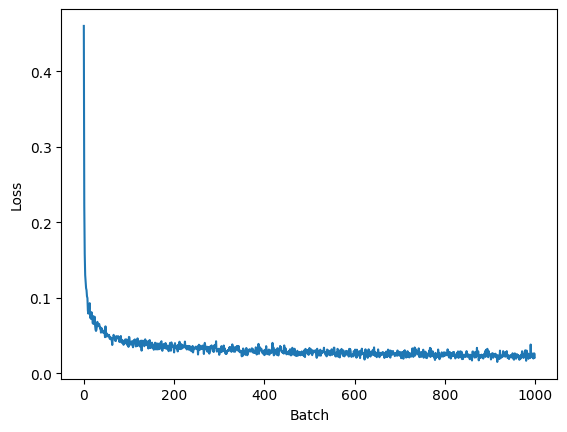

In [20]:
#Plot the history of the loss values over batches
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

# Test

In [21]:
#Load the testing dataset
test_ds, x_test, y_test = load_dataset(dataset, split="test", is_training=False, repeat = False, batch_size=n_batch)
test = iter(test_ds)

In [22]:
#Load a non-repeating copy of the training dataset
train2 = iter(load_dataset(dataset, split="train", is_training=False, repeat = False, batch_size=n_batch)[0])

In [23]:
#define a labmda to compute accuracy we can dispatch over batches
eval_fn = lambda x: model.apply(params_t, key, x)
eval_fn_spk = lambda x: model.apply(params_t, key, x, spiking=True)

In [24]:
#compute the test set accuracy
preds = jnp.concatenate([accuracy_quadrature(eval_fn(b['image']), b['label']) for b in iter(test_ds)])
print("Test set accuracy is ", jnp.mean(preds))

Test set accuracy is  0.85469997


In [25]:
b = next(iter(test_ds))

In [43]:
ph_32 = model.apply(params_t, key, b['image'], repeats = 3, leakage = -0.2, spiking = True)

In [44]:
ph_32.shape

(128, 10, 11)

In [45]:
ns = model.apply(params_t, key, b['image'])

In [46]:
ns[0,...]

DeviceArray([ 0.00769967,  0.03413293,  0.0311584 ,  0.01508926,
              0.50299   , -0.00722854,  0.10368886, -0.01831889,
              0.02926692, -0.00219678], dtype=float32)

In [47]:
ph_32[0][:,2]

array([-1.  ,  0.  ,  0.8 ,  0.  ,  0.66, -0.08,  0.78, -1.  ,  0.86,
        0.  ])

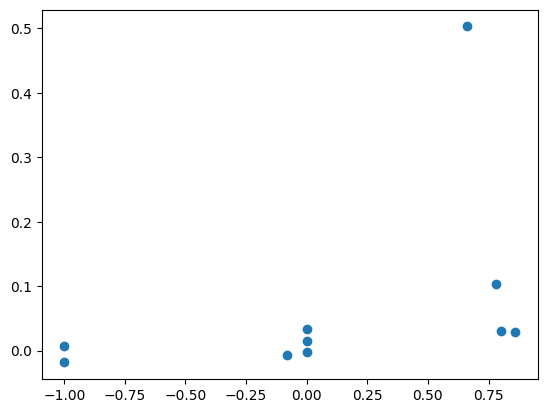

In [48]:
plt.scatter(ph_32[0][:,2], ns[0,...])

In [49]:
ph_10 = model.apply(params_t, key, b['image'], repeats = 1, leakage = 0.0, spiking = True)

In [50]:
ph_20 = model.apply(params_t, key, b['image'], repeats = 2, leakage = -0.2, spiking = True)

In [51]:
acc32 = accuracy_quadrature(ph_32, b['label'])

In [52]:
acc10 = accuracy_quadrature(ph_10, b['label'])
acc20 = accuracy_quadrature(ph_20, b['label'])

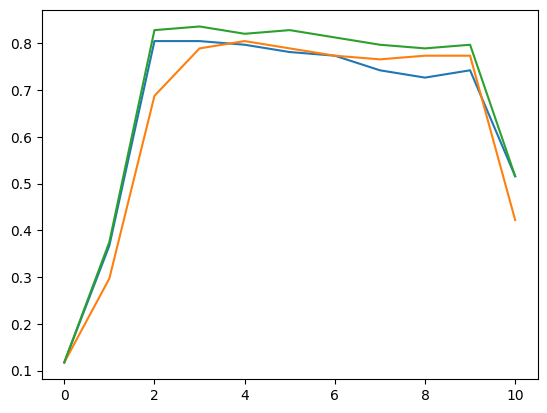

In [53]:
plt.plot(np.mean(acc32, axis=1))
plt.plot(np.mean(acc10, axis=1))
plt.plot(np.mean(acc20, axis=1))

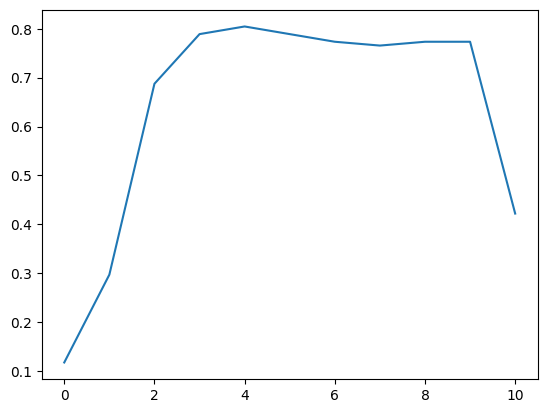

In [45]:
eval_fn_spk = lambda x: model.apply(params_t, key, x, spiking=True,)
phase = eval_fn_spk(x)

Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 565.26it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5038.89it/s]


In [53]:
phase_spk = [eval_fn_spk(b['image']) for b in iter(test_ds)]

Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 480.01it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5056.58it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 520.44it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5092.63it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 509.65it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5116.10it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 522.37it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5104.85it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 528.38it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5089.92it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 508.44it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5053.80it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 509.98it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5127.92it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 524.45it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5124.13it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 505.23it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5062.44it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 493.03it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5156.76it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 526.06it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4938.77it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 526.58it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5076.55it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 521.77it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5108.99it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 527.65it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5075.44it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 534.50it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4978.07it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 535.81it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5114.84it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 525.33it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5095.61it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 533.48it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5149.23it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 501.07it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5051.24it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 525.37it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5082.64it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 523.89it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4956.11it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 519.96it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4947.14it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 530.92it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5114.29it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 528.59it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4166.26it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 500.46it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5071.70it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 528.33it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5081.01it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 525.03it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4915.89it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 524.32it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5041.81it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 517.62it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5114.06it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 533.94it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4906.12it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 533.77it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4859.17it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 508.69it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4738.33it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 517.01it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5047.42it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 522.52it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5013.30it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 514.49it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5072.21it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 531.15it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5115.20it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 508.60it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4656.70it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 526.68it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5052.08it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 512.11it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4143.48it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 521.10it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4707.64it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 521.66it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5118.58it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 519.28it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5097.99it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 515.74it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5098.66it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 528.35it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4332.08it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 532.83it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4925.62it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 506.60it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5089.35it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 537.19it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4475.69it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 532.67it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4907.37it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 517.57it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5083.80it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 519.55it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4933.75it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 541.95it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4294.23it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 590.66it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4564.79it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 517.85it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5099.31it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 533.50it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5029.70it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 582.12it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4335.67it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 569.95it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4961.17it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 519.80it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5050.25it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 531.26it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5025.60it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 503.93it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5008.36it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 515.45it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5105.27it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 516.30it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4924.53it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 526.17it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4234.50it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 517.62it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5047.30it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 557.88it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4485.07it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 514.24it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5098.19it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 506.88it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5104.46it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 523.33it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5127.07it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 528.99it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5085.48it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 523.68it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5082.63it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 530.03it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5062.34it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 522.73it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5060.28it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 502.47it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5083.20it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 505.97it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4296.97it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 527.06it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4845.51it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 533.27it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5044.62it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 450.56it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5052.45it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 515.30it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5043.46it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 536.65it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5006.08it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:00<00:00, 2502.14it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 6715.95it/s]


In [54]:
phase_spk[0].shape

(128, 10, 11)

In [55]:
ap2 = jnp.concatenate(phase_spk, axis=0)

In [56]:
ap2.shape

(10000, 10, 11)

In [57]:
dap = jnp.diff(ap2, axis=2)

In [58]:
dap_mean = jnp.mean(rearrange(dap, "a b c -> (a b) c"), axis=0)

In [59]:
dap_mean.shape

(10,)

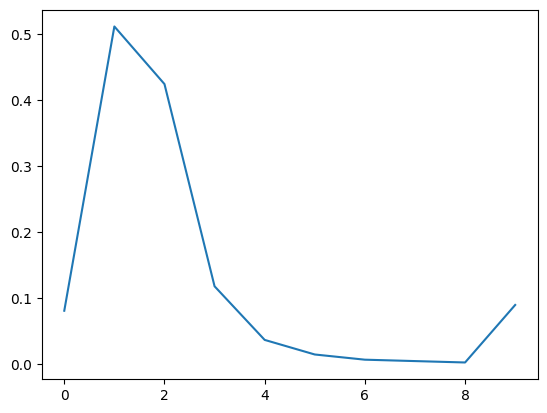

In [61]:
plt.plot(jnp.abs(dap_mean))

In [63]:
dphase_postmax(ap2)

2

In [64]:
aa2 = accuracy_quadrature(ap2, y_test)

In [65]:
aa2.shape

(11, 10000)

In [66]:
jnp.mean(aa2[2,:])

DeviceArray(0.8261, dtype=float32)

In [46]:
preds_spk = [accuracy_quadrature(eval_fn_spk(b['image']), b['label']) for b in iter(test_ds)]

Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 501.24it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5039.06it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 599.18it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4854.89it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 510.59it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4871.09it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 493.69it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4226.75it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 481.08it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5003.25it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 542.06it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4194.30it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 546.15it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5075.32it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 607.60it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5024.48it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 526.89it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5050.86it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 551.15it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5066.58it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 466.57it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5050.94it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 563.06it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4812.15it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 553.98it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5099.31it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 602.89it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5098.17it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 559.76it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5100.89it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 590.51it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5100.94it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 591.44it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5090.78it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 565.52it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4334.57it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 561.70it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5059.44it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 564.77it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5039.06it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 553.91it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4964.57it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 555.36it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5064.91it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 571.88it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5099.60it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 567.58it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5068.66it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 543.08it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5079.00it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 555.77it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5086.59it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 550.39it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5041.35it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 549.56it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4579.47it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 545.95it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4794.36it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 553.68it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5075.04it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 532.80it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4969.81it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 586.14it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5096.33it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 589.85it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5013.04it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 554.10it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5033.21it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 559.67it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5100.76it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 480.89it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 3601.89it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 454.32it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4476.78it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 470.32it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4953.63it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 520.87it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4930.62it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 467.02it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5015.13it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 430.19it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5145.92it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 520.01it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4870.93it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 548.12it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 3724.17it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 580.30it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5003.00it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 561.99it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5088.13it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 543.58it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5070.34it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 528.94it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4882.21it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 558.72it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4029.86it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 558.54it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5026.41it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 549.28it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5051.42it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 529.27it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4209.90it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 532.33it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4928.34it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 553.15it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4971.10it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 537.81it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5022.78it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 525.58it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5009.23it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 554.13it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4979.55it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 555.86it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4401.74it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 525.30it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5002.20it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 537.27it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5026.64it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 511.98it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5099.70it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 543.52it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5010.18it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 518.27it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5013.20it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 518.03it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5057.52it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 541.80it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4865.03it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 526.26it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5020.01it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 527.65it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 3875.34it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 527.40it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4976.81it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 534.48it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4975.44it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 513.29it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5030.00it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 487.12it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4977.12it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 513.97it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4954.54it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 508.24it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5011.36it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 515.19it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5071.82it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 523.25it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5052.24it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 522.14it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5084.39it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 530.09it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5038.63it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 521.19it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4255.36it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 519.71it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5017.57it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:00<00:00, 2333.84it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4681.30it/s]


In [47]:
len(preds_spk)

79

In [50]:
ap = jnp.concatenate(preds_spk, axis=1)

In [51]:
ap.shape

(11, 10000)

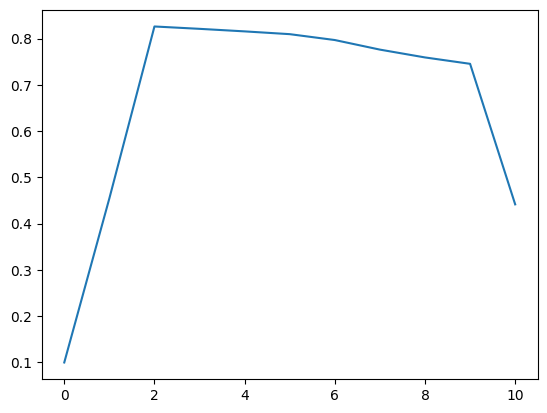

In [52]:
plt.plot(jnp.mean(ap, axis=1))

In [24]:
#compute train set accuracy
preds_t = jnp.concatenate([acc_fn(b) for b in train2])
print("Train set accuracy is ", jnp.mean(preds_t))

Train set accuracy is  0.89565


Text(0.5, 1.0, 'Post-Train Phases')

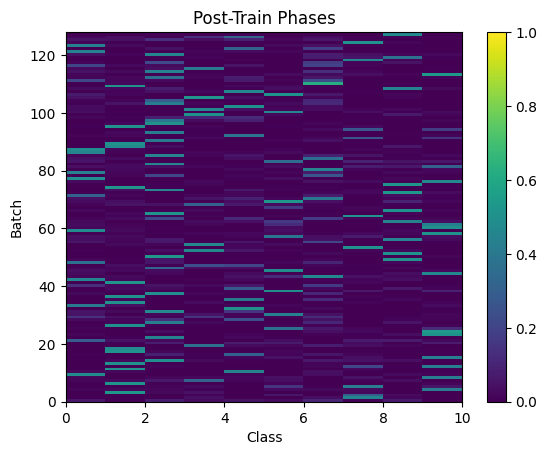

In [25]:
#Visualize the similarity each sample produces to the class codebook
sim2 = model.apply(params_t, key, x)

plt.pcolor(sim2, vmax=1.0, vmin=0.0)
plt.xlabel("Class")
plt.ylabel("Batch")
plt.colorbar()
plt.title("Post-Train Phases")

In [26]:
accs = accuracy_quadrature(model, key, params_t, x, y, spiking=True)
spiking_acc = jnp.mean(accs, axis=1)

Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 533.83it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 3679.40it/s]


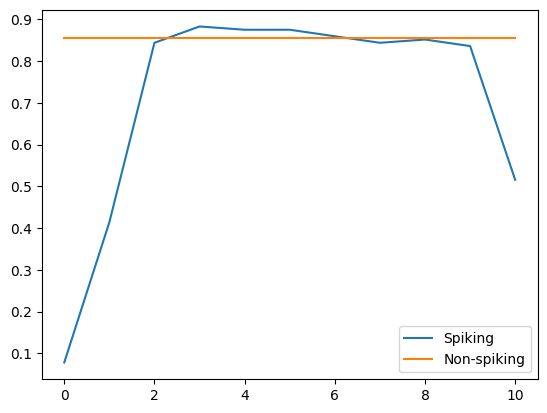

In [27]:
plt.plot(spiking_acc, label="Spiking")
plt.plot(jnp.ones_like(spiking_acc)* jnp.mean(preds), label="Non-spiking")
plt.legend()